In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [3]:
year_suffix = input('Enter the water year suffix (e.g. 04 for WY2004): ')
run_name = 'salmon_current_WY'+str(year_suffix)
summa = xr.open_dataset('../model/output/salmon_meadows/output_'+run_name+'_timestep.nc')

snotel = pd.read_csv('../model/snotel_csvs/salmon_WY'+str(year_suffix)+'.csv', index_col='time', parse_dates=True)

/home/cdalden/miniforge3/envs/pysumma/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# mask out bad snow depth data
snotel['SNOWDEPTH'] = snotel['SNOWDEPTH'][snotel['SNOWDEPTH'] > 0]
# Calculate the difference between timesteps
diff = snotel['SNOWDEPTH'].diff()
# Mask out all data where the difference between timesteps is more than 0.5
snotel['SNOWDEPTH'] = snotel['SNOWDEPTH'][diff.abs() <= 6]
snotel['SNOWDEPTH'] = snotel['SNOWDEPTH'].interpolate(method='linear')

# mask out bad SWE data
snotel['SWE'] = snotel['SWE'][snotel['SWE'] > 0]
snotel['SWE'] = snotel['SWE'].interpolate(method='linear')

# calculate density
summa['density'] = (summa['scalarSWE'])/summa['scalarSnowDepth']
snotel['density_obs'] = (snotel['SWE']*25.4)/(snotel['SNOWDEPTH']*0.0254)

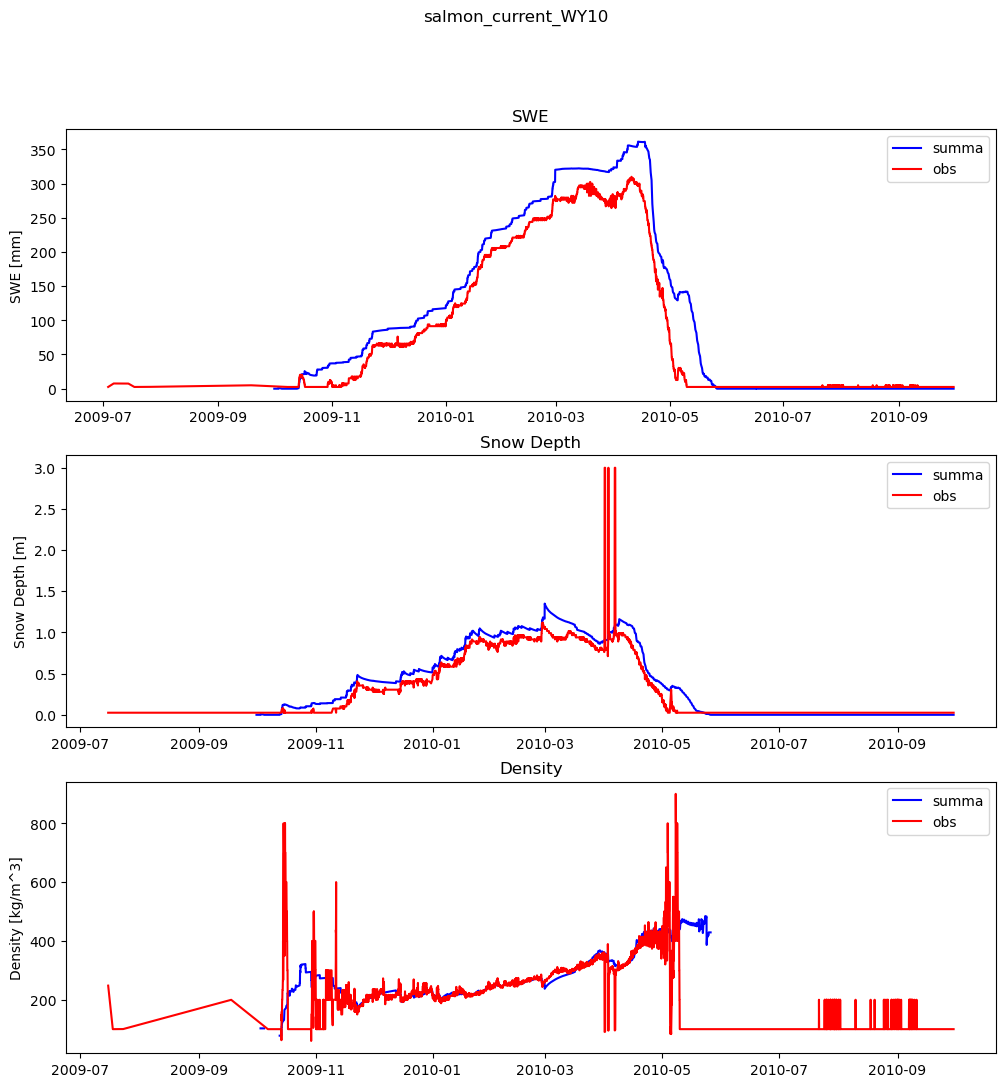

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle(run_name)

ax[0].plot(summa['time'], summa['scalarSWE'], label='summa', color='blue')
ax[0].plot(snotel.index, snotel['SWE']*25.4, label='obs', color='red')
ax[0].set_title('SWE')
ax[0].set_ylabel('SWE [mm]')
ax[0].legend()

ax[1].plot(summa['time'], summa['scalarSnowDepth'], label='summa', color='blue')
ax[1].plot(snotel.index, snotel['SNOWDEPTH']*0.0254, label='obs', color='red')
ax[1].set_title('Snow Depth')
ax[1].set_ylabel('Snow Depth [m]')
ax[1].legend()

ax[2].plot(summa['time'], summa['density'], label='summa', color='blue')
ax[2].plot(snotel.index, snotel['density_obs'], label='obs', color='red')
ax[2].set_title('Density')
ax[2].set_ylabel('Density [kg/m^3]')
ax[2].legend()

In [6]:
# Convert 'density' DataArray in 'summa' to DataFrame
density_df = summa['density'].to_dataframe()
# Reset the index
density_df = density_df.reset_index()
# Set 'time' as the index
density_df = density_df.set_index('time')
# Drop the 'hru' column
density_df = density_df.drop(columns='hru')

# Round the DateTimeIndex of 'density_df' to the nearest hour
density_df.index = density_df.index.round('H')

# Round the DateTimeIndex of 'snotel' to the nearest hour
snotel.index = snotel.index.round('H')

# Make the DateTimeIndex of 'density_df' timezone-naive
density_df.index = density_df.index.tz_localize(None)

# Make the DateTimeIndex of 'snotel' timezone-naive
snotel.index = snotel.index.tz_localize(None)

# Subtract 'density' in 'snotel' from 'density' in 'density_df'
difference = density_df['density'] - snotel['density_obs']

# Subtract 'density' in 'snotel' from 'density' in 'density_df'
difference = density_df['density'] - snotel['density_obs']

# Drop NaN values
difference = difference.dropna()

/tmp/ipykernel_7987/252149538.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  density_df.index = density_df.index.round('H')
/tmp/ipykernel_7987/252149538.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  snotel.index = snotel.index.round('H')


In [7]:
# Mask out all data that is not between December and March
masked_difference = difference[(difference.index.month >= 12) | (difference.index.month <= 3)]

In [30]:
mean_den_dif = masked_difference.mean()

# Generate the years
# years = [str(i).zfill(2) for i in range(24)]

# Create a DataFrame with the column 'mean_den_dif' filled with nan and 'year' as the index
# df = pd.DataFrame({'mean_den_dif': np.nan}, index=years)
df = pd.read_csv('den_eval.csv', index_col=0)

# Find the row with index='year_suffix' and assign 'mean_den_dif'
df.loc[str(year_suffix), 'mean_den_dif'] = mean_den_dif

# Append the DataFrame to the CSV file (and create it if it doesn't exist)
df.to_csv('den_eval.csv')


In [31]:
df

,mean_den_dif
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [10]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
fig.suptitle(run_name)

ax[0].plot(summa['time'], summa['density'], label='summa', color='blue')
ax[0].plot(snotel.index, snotel['density_obs'], label='obs', color='red')
ax[0].set_title('Density')
ax[0].set_ylabel('Density [kg/m^3]')
ax[0].set_ylim([100, 500])
ax[0].legend()

ax[1].plot(masked_difference.index, masked_difference, label='difference', color='green')
ax[1].set_title('Difference')
ax[1].set_ylabel('Density [kg/m^3]')
ax[1].set_xlim([masked_difference.index[0], masked_difference.index[-10]])
ax[1].set_ylim([-100, 100])
ax[1].axhline(y=0, color='black', linestyle='--')
ax[1].legend()

plt.close()



Text(0, 0.5, 'Frequency')

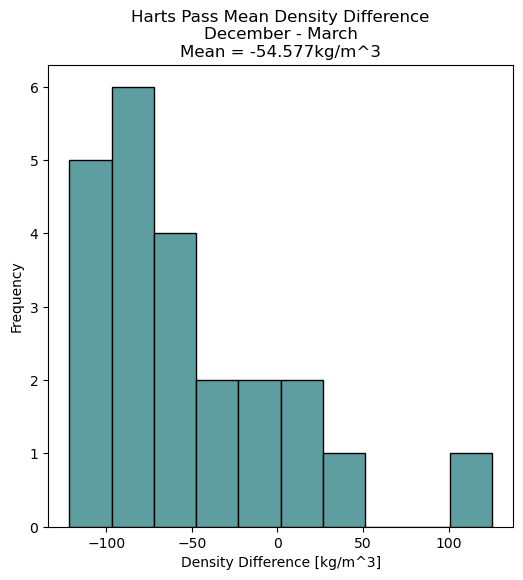

In [51]:
data = pd.read_csv('den_eval.csv', index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(data['mean_den_dif'], bins=10, color='cadetblue', edgecolor='black')
ax.set_title(f'Harts Pass Mean Density Difference\nDecember - March\nMean = {np.round(data.mean_den_dif.mean(),3)}kg/m^3')
ax.set_xlabel('Density Difference [kg/m^3]')
ax.set_ylabel('Frequency')